In [1]:
import torch
import torch.nn as nn
import pdb

import os
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import cv2

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('/mnt/fyp')  
from preprocessing.make_dataset import GestureDataset

In [3]:
'''
def darken(rgb_img):
    gray_img = rgb_img.mean(dim=1, keepdim=True).float()
    gray_img = torch.clamp(gray_img - 5, min=0)
    rgb_img_after = gray_img.repeat(1,3,1,1).float()
    return rgb_img_after
'''

'\ndef darken(rgb_img):\n    gray_img = rgb_img.mean(dim=1, keepdim=True).float()\n    gray_img = torch.clamp(gray_img - 5, min=0)\n    rgb_img_after = gray_img.repeat(1,3,1,1).float()\n    return rgb_img_after\n'

In [24]:
def darken(rgb_imgs, brightness_factor):
    # rgb_img: tensor, 64*3*224*224
    # opencv's cv2.COLOR_RGB2GRAY can only be used on numpy, not tensor
    rgb_imgs = rgb_imgs.cpu().numpy() # rgb_img: numpy,64*3*224*224
    gray_imgs = []
    for i in range(rgb_imgs.shape[0]):
        rgb_img = np.transpose(rgb_imgs[i], (1, 2, 0))  # numpy: 3*224*224 → 224*224*3, because opencv needs channel to be the last dimension
        gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
        gray_imgs.append(gray_img)
    
    # change brightness
    dark_gray_imgs = [(gray_img * brightness_factor).astype(np.uint8) for gray_img in gray_imgs] 
    
    # dark_gray_imgs = [np.clip(gray_img * brightness_factor, 0, 255).astype(np.uint8) for gray_img in gray_imgs]
    
    # change back to RGB
    dark_rgb_imgs = []
    for dark_gray_img in dark_gray_imgs:
        dark_rgb_img = cv2.cvtColor(dark_gray_img, cv2.COLOR_GRAY2RGB)
        dark_rgb_imgs.append(dark_rgb_img)
        
    # output
    dark_res = torch.stack([torch.from_numpy(np.transpose(dark_rgb_img, (2, 0, 1))) for dark_rgb_img in dark_rgb_imgs])
    dark_res = dark_res.to(torch.float32)
    # tensor, 64*3*224*224
    
    return dark_res

In [25]:
device = torch.device("cuda:0")

In [31]:
loader = torch.load("/mnt/fyp/data/train_loader.pt")

brightness_factor = 1

for idx, batch in enumerate(loader):
    img = batch['data'][:,:3*224*224].reshape(-1,3,224,224) # 64*3*224*224, 4D
    # img = darken(img, brightness_factor)
    
    tmp = img[0].cpu().numpy()
    tmp = np.transpose(tmp,(1,2,0))
    np.save("/mnt/fyp/lux/you.png",tmp)
    break

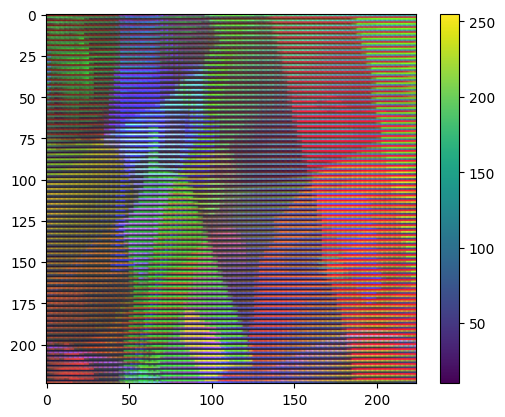

In [32]:
img = np.load("/mnt/fyp/lux/you.png.npy")

img = Image.fromarray(np.uint8(img)) 

plt.imshow(img)
plt.colorbar() 
plt.show()

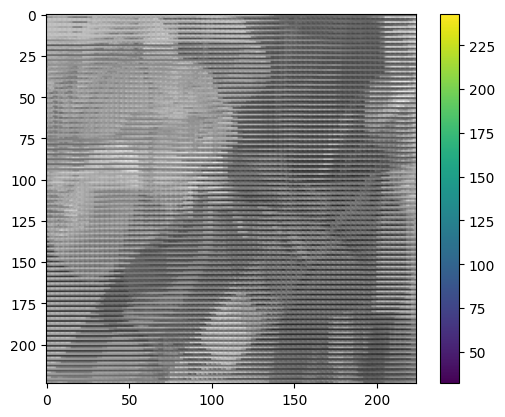

In [27]:
img = np.load("/mnt/fyp/lux/you.png.npy")

img = Image.fromarray(np.uint8(img)) 

plt.imshow(img)
plt.colorbar() 
plt.show()

In [30]:
img = np.array(img)
img.shape

(224, 224, 3)

In [21]:
dark_img = np.load("/mnt/fyp/lux/dark_img.npy")
img = dark_img[0]

In [22]:
img.shape

(3, 224, 224)

In [24]:
transpose_img = np.transpose(img, (1, 2, 0))
clip_img = np.clip(transpose_img, 0, 1)

from PIL import Image
new_img = Image.fromarray((clip_img * 255).astype('uint8'))
new_img.show()

In [8]:
model = torch.load('/mnt/fyp/models/img_teng_imu_model.pth')

model.eval()

loader = torch.load("/mnt/fyp/data/val_loader.pt")

for idx, batch in enumerate(loader):
    img = batch['data'][:,:3*224*224].reshape(-1,3,224,224) # 64*3*224*224, 4D
    dark_img = darken(img).to(device) # 64*3*224*224, 4D
    
    teng = batch['data'][:,224*224*3:224*224*3+500].reshape(-1,50,10).to(device)
    
    imu = batch['data'][:,224*224*3+500:].reshape(-1,50,18).to(device) 
    
    label = batch['label'].to(torch.long).to(device).squeeze()
    
    if idx==0:
        gt = label
    else:
        gt = torch.cat((gt, label), dim=0)
    
    outputs = model(dark_img, teng, imu)

    _, predicted = torch.max(outputs, 1) 
    
    if idx==0:
        predict = predicted
    else:
        predict = torch.cat((predict, predicted), dim=0)
    

In [9]:
gt == predict

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, 